Enter the path of the extracted dataset folder:  D:\Parkinsont


Detected classes: ['DCM_Images-20231213T092329Z-001', 'Disease_Prediction-20231213T083430Z-001']
Skipping D:\Parkinsont\DCM_Images-20231213T092329Z-001\DCM_Images\PPMI_101179_MR_2D_GRE_MT__br_raw_20220419213501029_1_S1126241_I1571517.dcm: cannot identify image file <_io.BytesIO object at 0x000001CD4164DB20>
Skipping D:\Parkinsont\DCM_Images-20231213T092329Z-001\DCM_Images\PPMI_101492_MR_rsfMRI_RL__br_raw_20210916224845964_1_S1063557_I1493084(1).dcm: cannot identify image file <_io.BytesIO object at 0x000001CD4164DB20>
Skipping D:\Parkinsont\DCM_Images-20231213T092329Z-001\DCM_Images\PPMI_101492_MR_rsfMRI_RL__br_raw_20210916224845964_1_S1063557_I1493084.dcm: cannot identify image file <_io.BytesIO object at 0x000001CD4164DB20>
Skipping D:\Parkinsont\DCM_Images-20231213T092329Z-001\DCM_Images\PPMI_103542_MR_rsfMRI_LR__br_raw_20220106125045401_2_S1093544_I1530517.dcm: cannot identify image file <_io.BytesIO object at 0x000001CD4164DB20>
Skipping D:\Parkinsont\DCM_Images-20231213T092329Z-0

D:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.6810 - loss: 0.7673 - val_accuracy: 1.0000 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 1.0000 - loss: 9.2359e-11 - val_accuracy: 1.0000 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 1.0000 - loss: 5.4025e-09 - val_accuracy: 1.0000 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 1.0000 - loss: 2.4320e-07 - val_accuracy: 1.0000 - val_loss: 7.0984e-04 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 1.0000 - loss: 9.8643e-11 - val_accuracy: 1.0000 - val_loss: 1.1538e-04 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 1.0000 - loss: 6.2913e-04 - val_accuracy: 1.0000 - val_loss: 1.1115e-06 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 1.0000

Fold 4 Validation Loss: 0.0 - Accuracy: 1.0
Model saved as parkinsons_detector.h5


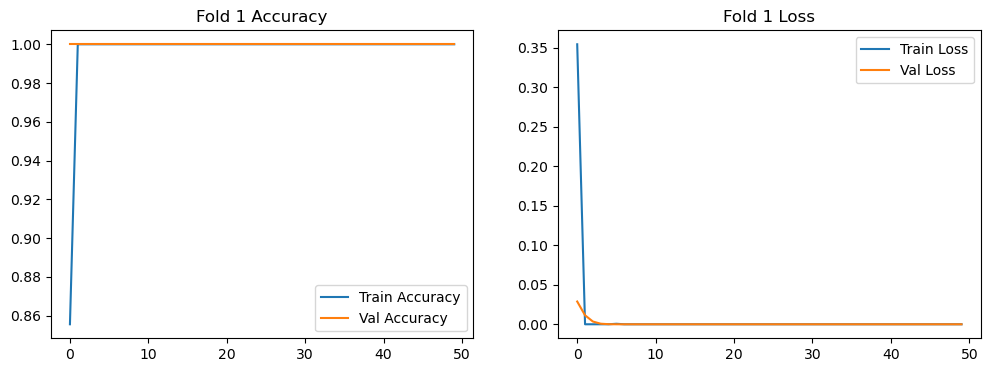

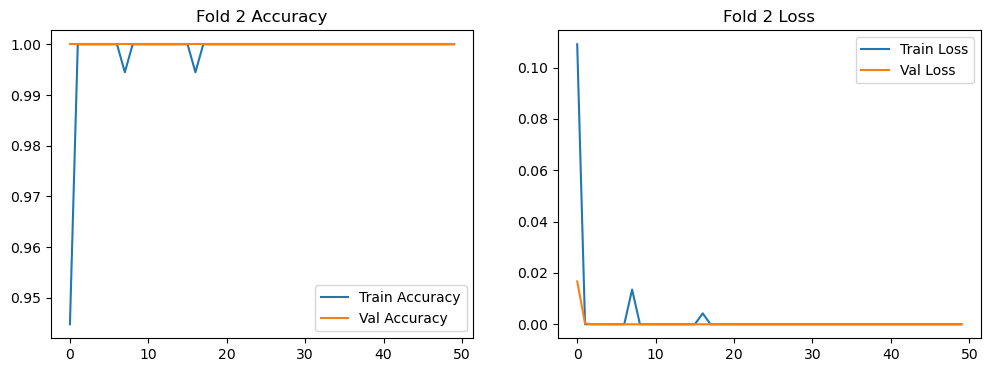

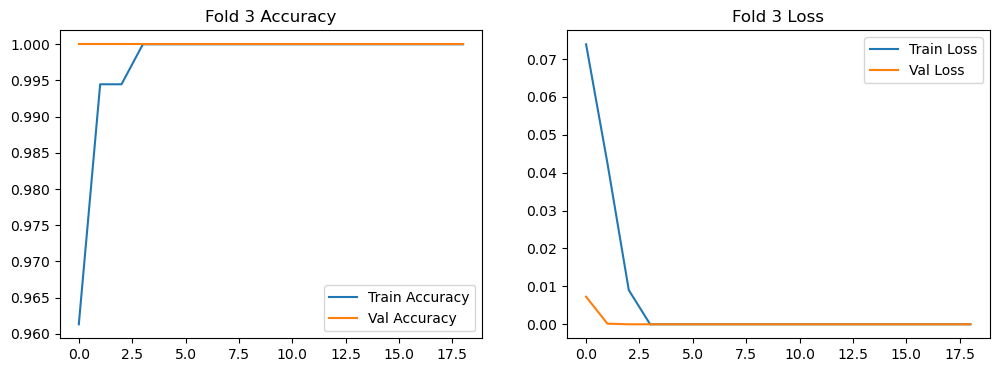

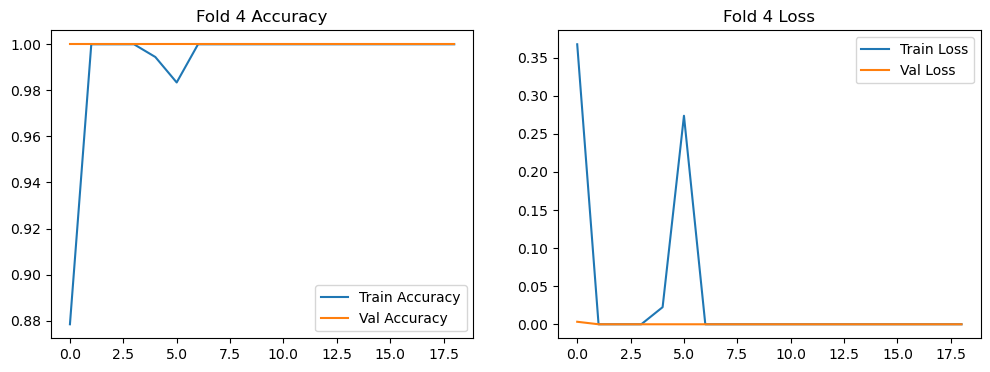

Enter the path of the fMRI image to predict:  D:\download.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Prediction: Parkinson Detected


In [12]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Config
img_height = 128
img_width = 128
batch_size = 32
epochs = 50
num_folds = 4

# Load images function
def load_images_and_labels(dataset_dir, img_height, img_width):
    images = []
    labels = []
    classes = sorted(os.listdir(dataset_dir))
    print(f"Detected classes: {classes}")
    
    class_to_index = {class_name: idx for idx, class_name in enumerate(classes)}
    
    for class_name in classes:
        class_path = os.path.join(dataset_dir, class_name)
        for root, _, files in os.walk(class_path):
            for file in files:
                img_path = os.path.join(root, file)
                try:
                    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.utils.img_to_array(img)
                    images.append(img_array)
                    labels.append(class_to_index[class_name])
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")
    
    return np.array(images), np.array(labels), classes

# Ask user for path
dataset_dir = input("Enter the path of the extracted dataset folder: ")

X, y, classes = load_images_and_labels(dataset_dir, img_height, img_width)
X = X / 255.0

print(f"Total images loaded: {len(X)}")

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Model Creation
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 4-Fold Cross Validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1
histories = []
for train_idx, val_idx in kf.split(X):
    print(f'\nTraining for fold {fold_no}...')
    model = create_model()

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        callbacks=[earlystop, reduce_lr])

    histories.append(history)

    # Evaluation
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} Validation Loss: {scores[0]} - Accuracy: {scores[1]}")

    fold_no += 1

# Save the model
model_save_path = 'parkinsons_detector.h5'
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Plotting
def plot_histories(histories):
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'Fold {i+1} Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Fold {i+1} Loss')
        plt.legend()

        plt.show()

plot_histories(histories)

# Prediction
def predict_on_image(model_path):
    model = load_model(model_path)
    user_path = input("Enter the path of the fMRI image to predict: ")

    try:
        img = tf.keras.utils.load_img(user_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)
        result = 'Parkinson Detected' if prediction[0][0] >= 0.5 else 'Healthy'
        print(f"Prediction: {result}")
    except Exception as e:
        print(f"Error loading or predicting image: {e}")

predict_on_image(model_save_path)
